# NIR to Brian2 demo: Synfire Chain

This notebook let's you look behind the scenes of NIR:

1. NIR Graph: its data structure and how to construct it
2. How to convert a NIR graph to a `brian2.Network` with brian2's neuron groups and synapses object

In [1]:
import nir
import brian2
import matplotlib.pyplot as plt
import numpy as np

from numpy.random import default_rng

rng = default_rng()

## Synfire Chain
TODO: add figure and describe the architecture

In [2]:
n_groups = 5
n_nrns = 100  # neurons per group
p_conn = 0.6
weight = 1.0

# neuron params
R = 1.0
v_threshold = 50.0

def gen_weights_fixed_probability(n_pre: int, n_post:int, p:float, weight: float):
    r = rng.random((n_post, n_pre))
    weights = np.zeros((n_post, n_pre), dtype=float)
    weights[r<p] = weight
    return weights

In [3]:
nodes = {}
nodes["input"] = nir.Input(input_type=np.array([n_nrns]))
for i in range(n_groups):
    nodes[f"linear_{i}"] = nir.Linear(weight=gen_weights_fixed_probability(n_nrns, n_nrns, p_conn, weight))
    nodes[f"if_{i}"] = nir.IF(r=np.full(n_nrns, R), v_threshold=np.full(n_nrns, v_threshold))
    nodes[f"output_{i}"] = nir.Output(output_type=np.array([n_nrns]))

In [4]:
nodes

{'input': Input(input_type={'input': array([100])}),
 'linear_0': Linear(weight=array([[0., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 0., 1.],
        ...,
        [1., 1., 0., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 0., 1.],
        [1., 1., 1., ..., 1., 1., 0.]])),
 'if_0': IF(r=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), v_threshold=array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
        50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
        50., 50., 50., 50., 50., 50., 50., 50., 50.

In [5]:
edges = []
edges.append(("input", "linear_0"))
for i in range(n_groups):
    edges.append((f"linear_{i}", f"if_{i}"))
for i in range(n_groups-1):
    edges.append((f"if_{i}", f"linear_{i+1}"))
for i in range(n_groups):
    edges.append((f"if_{i}", f"output_{i}"))

In [6]:
edges

[('input', 'linear_0'),
 ('linear_0', 'if_0'),
 ('linear_1', 'if_1'),
 ('linear_2', 'if_2'),
 ('linear_3', 'if_3'),
 ('linear_4', 'if_4'),
 ('if_0', 'linear_1'),
 ('if_1', 'linear_2'),
 ('if_2', 'linear_3'),
 ('if_3', 'linear_4'),
 ('if_0', 'output_0'),
 ('if_1', 'output_1'),
 ('if_2', 'output_2'),
 ('if_3', 'output_3'),
 ('if_4', 'output_4')]

In [7]:
graph = nir.NIRGraph(nodes=nodes, edges=edges)

# Create brian2 network
Create a `brian2.Network` and dictionairy to keep track of neuron groups, synapses and spike_monitors

In [8]:
net = brian2.Network()
neuron_groups = {}
synapses = {}
spike_monitors = {}

## 1. Create NeuronGroups from NIR graph

Let's create NeuronGroups from `nir.IF` and `nir.Input` nodes.

- `IF` nodes are converted into `brian2.NeuronGroup` objects with matching neuron model equations.
- `Input` nodes are converted into `brian2.SpikeGeneratorGroup` objects 

In [9]:
# Loop over graph nodes and process IF and Input nodes
for name, node in graph.nodes.items():
    if isinstance(node, nir.IF):
        IF_eqn = """
        v : 1
        v_th : 1
        r : 1
        """

        shape = node.output_type["output"] # get output shape of NIR node
        # create a neuron group with IF model
        group = brian2.NeuronGroup(N=shape, model=IF_eqn, threshold="v>v_th", reset="v -= v_th")
        
        # set parameters
        group.r = node.r
        group.v_th = node.v_threshold

        neuron_groups[name] = group
      
    elif isinstance(node, nir.Input):
        shape = node.output_type["output"]  # get output shape of NIR node

        # create a spike generator group with empty spike times 
        indices = np.array([], dtype=int)
        times = np.array([], dtype=float)*brian2.ms
        group = brian2.SpikeGeneratorGroup(shape, indices=indices, times=times)

        neuron_groups[name] = group

# add neuron groups to brian2 network
net.add(*neuron_groups.values())

## 2. Create Synapses from NIR graph

Let's create `brian2.Synapses` from `nir.Linear` nodes.

In [10]:
# Loop over graph nodes and process IF and Input nodes
for name, node in graph.nodes.items():
    if isinstance(node, nir.Linear):
        # get weight matrix and reshape from (n_post, n_pre) to (n_pre, n_post)
        weight_matrix = node.weight.T
        
        # get source and target of Linear node by parsing the edges
        src_nodes = [src for (src, tgt) in graph.edges if tgt == name]
        tgt_nodes = [tgt for (src, tgt) in graph.edges if src == name]

        # make sure there is only 1 source and 1 target of the Linear node
        assert len(src_nodes) == 1
        assert len(tgt_nodes) == 1

        # get previously created source and target neuron groups
        src_group = neuron_groups[src_nodes[0]]
        tgt_group = neuron_groups[tgt_nodes[0]]

        # create synapses object
        syn = brian2.Synapses(src_group, tgt_group, model="w:1", on_pre="v += w")
        syn.connect() # connect full matrix
        syn.w = weight_matrix.flatten()
        
        synapses[name] = syn

# Add synapses to brian2 network
net.add(*synapses.values())

## 3. Create SpikeMonitors for Output notes

Let's use NIR's `Output` to set up the recording of the neuron groups with `brian2.SpikeMonitors`

In [11]:
# create state monitors
for name, node in graph.nodes.items():
    if isinstance(node, nir.Output):
        # get source node by parsing the edges
        src_nodes = [src for (src, tgt) in graph.edges if tgt == name]
        assert len(src_nodes) == 1
        spike_mon = brian2.SpikeMonitor(neuron_groups[src_nodes[0]])
        spike_monitors[name] = spike_mon

# Add spike monitors to brian2 network
net.add(*spike_monitors.values())

## 5. Verify that no nodes were missed

Let's check if all nodes in the NIR graph have been processed

In [12]:
# create a set with all the node names
node_names = set(graph.nodes.keys())

# remove nodes converted to neuron groups
for key in neuron_groups:
    node_names.remove(key)

# remove nodes converted to synapses objects
for key in synapses:
    node_names.remove(key)

# remove nodes converted to spike monitors
for key in spike_monitors:
    node_names.remove(key)

# Set of node names should be empty!
assert len(node_names) == 0

# Run simulation

Let's create input spikes

Text(0.5, 1.0, 'input spikes')

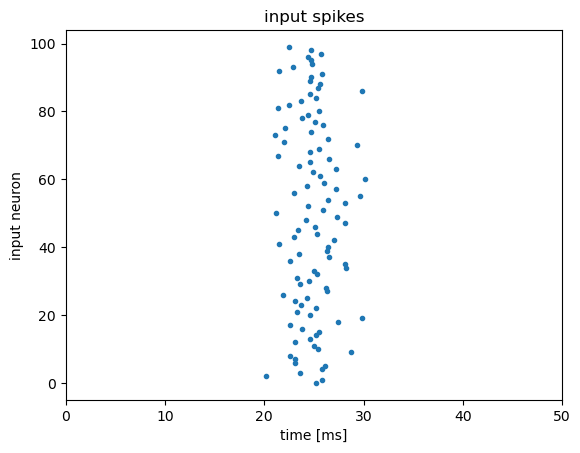

In [13]:
input_group = neuron_groups["input"]

s_mean = 25.0
s_sigma = 2.0
input_spikes = rng.normal(s_mean, s_sigma, n_nrns)
indices = np.arange(n_nrns, dtype=int)
times = input_spikes*brian2.ms
    
input_group.set_spikes(indices, times)

# plot input spike volley
plt.plot(times/brian2.ms, indices, ".")
plt.xlim(0,50)
plt.xlabel("time [ms]")
plt.ylabel("input neuron")
plt.title("input spikes")

In [16]:
# run brian2 simulation
net.run(50*brian2.ms, report="text")

Starting simulation at t=10. ms for a duration of 50. ms
50. ms (100%) simulated in < 1s


Text(0, 0.5, 'neuron ID')

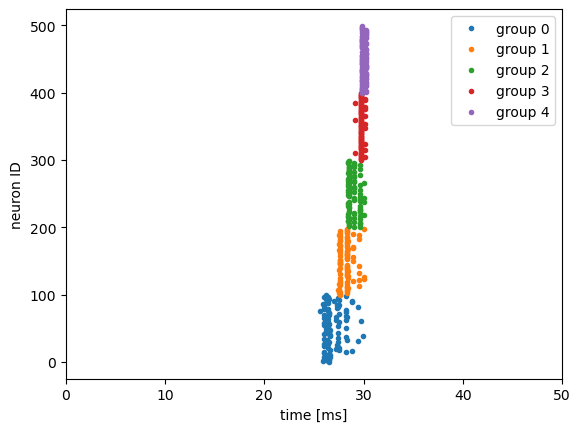

In [17]:
for i in range(n_groups):
    spike_mon = spike_monitors[f"output_{i}"]
    idx_offset = i*n_nrns
    plt.plot(spike_mon.t/brian2.ms, spike_mon.i + idx_offset, ".", label=f"group {i}")

plt.legend()
plt.xlim(0,50)
plt.xlabel("time [ms]")
plt.ylabel("neuron ID")